In [1]:
from scipy.special import expit
import numpy as np
import tensorly as tl
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from utils_binaryTensor_Sarah import (TensorModelWithGenetics, generate_survival_data,plot_genetic_effects_over_time, plot_gene_heatmap,
                                      plot_average_gene_effects, plot_basis_functions,
                                      plot_disease_probabilities, plot_survival_times)



Ok now we want to fit the model to the data using  the inference of Chenyin.

We are going to assume that U1(G) is solely a funciton of G and infludenced indepenently of C, so C will not be estimated.

 A1 and A2 in previous code: 

A1 (N x K) represents the average individual loadings across all time points.
A2 (D x K) represents the average disease loadings across all time points.
These can be thought of as the "time-independent" or "average" loadings for individuals and diseases respectively.

For each individual n and factor k, there are R1 coefficients that determine how that individual's loading on that factor varies over time.
 Similarly, for each disease d and factor k, there are R2 coefficients that determine how that disease's loading on that factor varies over time.

We will call these U1G_init and W_init. 

Now e'll project U1G_init onto the space spanned by the covariates (G) and the temporal basis (U2) first, and then solve for B. Here's the corrected initialization part:


Similarly, project W onto the space spanned by the temporal basis

In [2]:

def survival_likelihood(Y, S, theta):
    pi = expit(theta)
    log_likelihood = 0
    N, D, T = Y.shape
    for n in range(N):
        for d in range(D):
            t = S[n, d]
            if t != 0:
                log_likelihood += np.sum(np.log(1 - pi[n, d, :t] + 1e-10))
                log_likelihood += np.log(pi[n, d, t] + 1e-10)
            if t == 0:
                log_likelihood += np.sum(np.log(1 - pi[n, d, :] + 1e-10))
    return -log_likelihood/N


1. Model structure: U1G = G @ B + C
Known components:
G (genetic data)
C (non-genetic effects)
Unknown component:
B (genetic effects)
4. Optimization focus:
Since G and C are known, the only part of U1G that we need to optimize is B. This is why we're updating B directly in each iteration.
Gradient computation:
When we compute the gradient for B, we're essentially asking, "How should we change B to improve our model's fit, given the fixed G and C?"
6. Updating process:
We update B based on its gradient.
Then we recompute U1G using the updated B and the fixed G and C.
This new U1G is used to compute the new theta and evaluate the model's performance.
This approach allows us to:
Maintain the correct structure of U1G throughout the optimization.
Focus our optimization efforts solely on the unknown genetic effects (B).
Incorporate our knowledge of the non-genetic effects (C) without trying to re-estimate them.
```
U1G = G @ B + C
θ = λ_k ⊗ φ = (U1G ⊗1 U2) ⊗ (W ⊗_2 U3)
We want to find ∂L/∂B, where L is our loss function.
Using the chain rule:
∂L/∂B = ∂L/∂θ ∂θ/∂U1G ∂U1G/∂B
1. ∂L/∂θ is our L_nabla
∂θ/∂U1G = U2 ⊗ φ
∂U1G/∂B = G^T
Putting this together:
∂L/∂B = G^T @ [(L_nabla ⊗3 U2^T) ⊙ φ]
Where ⊙ is the Hadamard (element-wise) product.
In code, this translates to:
```


Ok now we want to fit the model to the data using  the inference of Chenyin.

In [3]:
N, P, D, K, R1, R2, T = 1000, 20, 5, 4, 3, 3, 50
true_model = TensorModelWithGenetics(N, P, D, K, R1, R2, T)

# Generate data (or use your existing data)
theta_true = true_model.compute_theta()
pi_true = expit(theta_true)/20
Y, S = generate_survival_data(pi_true, N, D, T)


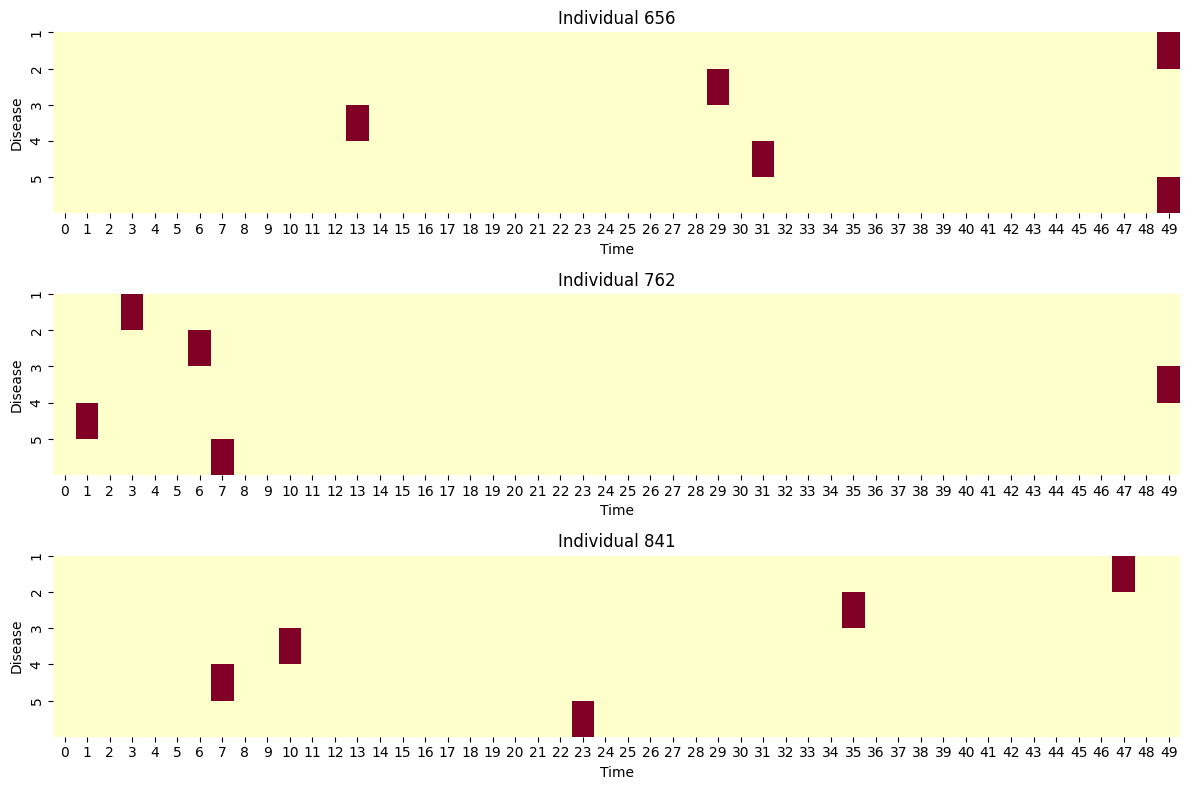

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select 3 random individuals
sample_individuals = np.random.choice(N, 3, replace=False)

# Create a figure
plt.figure(figsize=(12, 8))

# Create a subplot for each individual
for i, individual in enumerate(sample_individuals):
    plt.subplot(3, 1, i+1)
    
    # Create a matrix of event times for this individual
    event_matrix = np.zeros((D, T))
    for d in range(D):
        event_time = S[individual, d]
        event_matrix[d, event_time] = 1
    
    # Plot the heatmap
    sns.heatmap(event_matrix, cmap='YlOrRd', cbar=False)
    
    plt.title(f'Individual {individual}')
    plt.xlabel('Time')
    plt.ylabel('Disease')
    plt.yticks(range(D), range(1, D+1))

plt.tight_layout()
plt.show()

In [5]:
# Known parameters
G_known = true_model.G
C_known = true_model.C
U2 = true_model.U2
U3 = true_model.U3

 A1 and A2 in previous code: 

A1 (N x K) represents the average individual loadings across all time points.
A2 (D x K) represents the average disease loadings across all time points.
These can be thought of as the "time-independent" or "average" loadings for individuals and diseases respectively.

For each individual n and factor k, there are R1 coefficients that determine how that individual's loading on that factor varies over time.
 Similarly, for each disease d and factor k, there are R2 coefficients that determine how that disease's loading on that factor varies over time.

We will call these U1G_init and W_init. 

In [6]:
# Initialize B and W
# Initialize U1G and W
U1G_init, w, W_init = svds(Y.mean(axis=2), k=K)
U1G_init = U1G_init @ np.diag(np.sqrt(w))
W_init = (np.diag(np.sqrt(w)) @ W_init).T


Now e'll project U1G_init onto the space spanned by the covariates (G) and the temporal basis (U2) first, and then solve for B. Here's the corrected initialization part:


In [7]:
# Project U1G_init onto the space spanned by the covariates and temporal basis
U1G_init = np.repeat(U1G_init[:, :, np.newaxis], T, axis=2)
U1G_init = tl.tenalg.mode_dot(U1G_init, np.linalg.pinv(U2.T @ U2) @ U2.T, mode=2)
U1G = tl.tenalg.mode_dot(U1G_init, G_known @ np.linalg.pinv(G_known.T @ G_known) @ G_known.T, mode=0)


Similarly, project W onto the space spanned by the temporal basis

In [8]:
W = tl.tenalg.mode_dot(np.repeat(W_init[:, :, np.newaxis],T, axis=2),
                       np.linalg.pinv(U3.T @ U3) @ U3.T, mode=2)

# 

In [9]:
print("U1G_init stats:", np.min(U1G_init), np.max(U1G_init), np.mean(U1G_init))
print("W_init stats:", np.min(W_init), np.max(W_init), np.mean(W_init))

if np.any(np.isnan(U1G_init)) or np.any(np.isinf(U1G_init)):
    print("Warning: U1G_init contains NaN or inf values")
if np.any(np.isnan(W_init)) or np.any(np.isinf(W_init)):
    print("Warning: W_init contains NaN or inf values")

U1G_init stats: -0.013796756344845696 0.014839566734993778 0.0017854176429449608
W_init stats: -0.426334958090199 0.49382847977787175 0.11058649812736551


In [10]:
stepsize = .1
alpha = 0.5; beta = 0.8 # backtracking line search
rho = 1
stepsize_U1G = stepsize_W = stepsize 
# the time is the last mode (i.e, t_idx = 1)
t_idx = len(Y.shape) - 1
niters = 1000



def clip_gradient(grad, max_norm=1.0):
    norm = np.linalg.norm(grad)
    if norm > max_norm:
        grad = grad * (max_norm / norm)
    return grad

for it in range(niters):
    print(f"Starting iteration {it}")
    
    lambda_k = tl.tenalg.mode_dot(U1G, U2, 2)
    phi = tl.tenalg.mode_dot(W, U3, 2)
    
    

    if np.any(np.isnan(lambda_k)) or np.any(np.isinf(lambda_k)):
        print(f"Warning: lambda_k contains NaN or inf values at iteration {it}")
    if np.any(np.isnan(phi)) or np.any(np.isinf(phi)):
        print(f"Warning: phi contains NaN or inf values at iteration {it}")
    theta_pre = np.einsum("nkt,dkt->ndt", lambda_k, phi)
    
    if np.any(np.isnan(theta_pre)) or np.any(np.isinf(theta_pre)):
        print(f"NaN or inf detected in theta_pre at iteration {it}")
        break

    if np.any(np.isnan(theta_pre)) or np.any(np.isinf(theta_pre)):
        print(f"NaN or inf detected in theta_pre at iteration {it}")
        break   
    
    pi = np.clip(expit(theta_pre), 1e-10, 1 - 1e-10)
    L_nabla = np.zeros_like(theta_pre)
    for n in range(N):
        for d in range(D):
            t = S[n, d]
            if t != 0:
                L_nabla[n, d, :t] = pi[n, d, :t]
                if Y[n, d, t] == 1:
                    L_nabla[n, d, t] += -1
            if t == 0:
                L_nabla[n, d, :] = pi[n, d, :]

    L_nabla_mode0 = np.stack([tl.unfold(L_nabla[:, :, idx], mode=0) for 
                              idx in range(L_nabla.shape[t_idx])],
                             axis=t_idx)
    L_nabla_mode1 = np.stack([tl.unfold(L_nabla[:, :, idx], mode=1) for 
                              idx in range(L_nabla.shape[t_idx])],
                             axis=t_idx)
    
    loss_pre = survival_likelihood(Y, S, theta_pre)
    print(f"Pre-update loss: {loss_pre}")
    
    if np.isnan(loss_pre) or np.isinf(loss_pre):
        print(f"NaN or inf detected in loss_pre at iteration {it}")
        break
    
    grad_W = tl.tenalg.mode_dot(np.einsum('ijt,jkt->ikt', L_nabla_mode1, lambda_k),
                                U3.T, 2)
    grad_W = clip_gradient(grad_W)
    
    if np.any(np.isnan(grad_W)) or np.any(np.isinf(grad_W)):
        print(f"NaN or inf detected in grad_W at iteration {it}")
        break
    
    W_tilde = W - stepsize_W * grad_W
    phi_tilde = tl.tenalg.mode_dot(W_tilde, U3, 2)
    loss_after = survival_likelihood(Y, S, np.einsum("nkt,dkt->ndt", lambda_k, phi_tilde))
    
    if(loss_after > loss_pre - alpha * \
        stepsize_W * 1/np.linalg.norm(grad_W)):
        # return to previous stage
        stepsize_W *= beta
    else:
        W = W_tilde
        phi = tl.tenalg.mode_dot(W, U3, 2)
    
    # grad for U1G
    grad_U1G = tl.tenalg.mode_dot(np.einsum('jit,ikt->jkt', L_nabla_mode0, phi),
                                  U2.T, 2) #+ rho * U1G
    grad_U1G = clip_gradient(grad_U1G)
    
    U1G_tilde = U1G - stepsize_U1G * grad_U1G
    U1G_tilde = tl.tenalg.mode_dot(U1G_tilde, G_known @ np.linalg.pinv(G_known.T @ G_known) @ G_known.T, mode=0)

    # record the loss function post-GD
    ## with back-track line search
    lambda_k_tilde = tl.tenalg.mode_dot(U1G_tilde, U2, 2)
    loss_after = survival_likelihood(Y, S, np.einsum("nkt,dkt->ndt", lambda_k_tilde, phi))
    
    if(loss_after > loss_pre - alpha * \
        stepsize_U1G * 1/np.linalg.norm(grad_U1G)):
        # return to previous stage
        stepsize_U1G *= beta
    else:
        U1G = U1G_tilde
        lambda_k = tl.tenalg.mode_dot(U1G, U2, 2)
    
    theta_after = np.einsum("nkt,dkt->ndt", lambda_k, phi)
    
    loss_after = survival_likelihood(Y, S, theta_after)
    
    # record the relative loss change
    tol_temp = np.abs(np.linalg.norm(loss_pre) - np.linalg.norm(loss_after))/\
        np.linalg.norm(loss_pre)
    
    if not (it % 100):
        print(f'{it}th iteration with loss: {np.round(loss_after,3)}')
    
    if tol_temp < 1e-5 and (stepsize_U1G < 1e-6 or stepsize_W < 1e-6):
        print('Stop: not enough improvement')
        break

Starting iteration 0
Pre-update loss: 112.99752437276996
0th iteration with loss: 112.536
Starting iteration 1
Pre-update loss: 112.5358255327326
Starting iteration 2
Pre-update loss: 112.24218833737974
Starting iteration 3
Pre-update loss: 112.00595517239118
Starting iteration 4
Pre-update loss: 111.64891553999291
Starting iteration 5
Pre-update loss: 111.11939714662131
Starting iteration 6
Pre-update loss: 110.41093017048485
Starting iteration 7
Pre-update loss: 109.52527366277663
Starting iteration 8
Pre-update loss: 108.46693656310322
Starting iteration 9
Pre-update loss: 107.24205692675885
Starting iteration 10
Pre-update loss: 105.85806411701978
Starting iteration 11
Pre-update loss: 104.32353188010325
Starting iteration 12
Pre-update loss: 102.64808408092273
Starting iteration 13
Pre-update loss: 100.84231098199493
Starting iteration 14
Pre-update loss: 98.91768023763076
Starting iteration 15
Pre-update loss: 96.88643573490614
Starting iteration 16
Pre-update loss: 94.7614812903

In [11]:
# Time-varying individual loadings
lambda_k = tl.tenalg.mode_dot(U1G, U2, 2)  # Shape: (N, K, T)

# Time-varying disease weights
phi = tl.tenalg.mode_dot(W, U3, 2)  # Shape: (D, K, T)

# Full predicted tensor
theta_pred = np.einsum('nkt,dkt->ndt', lambda_k, phi)

# Predicted probabilities
pi_pred = expit(theta_pred)

In [12]:
U1G[1:10,0,:]
expit(theta_true[1:10,0,:])

array([[4.35773446e-01, 6.51041886e-01, 7.75274549e-01, 8.36173112e-01,
        8.62751951e-01, 8.69738166e-01, 8.63221907e-01, 8.45135996e-01,
        8.15579710e-01, 7.74235247e-01, 7.21501177e-01, 6.59347760e-01,
        5.91538674e-01, 5.22970688e-01, 4.58425669e-01, 4.01453597e-01,
        3.53924613e-01, 3.16244374e-01, 2.87882516e-01, 2.67886011e-01,
        2.55229597e-01, 2.48996242e-01, 2.48435366e-01, 2.52948418e-01,
        2.62036628e-01, 2.75232484e-01, 2.92029345e-01, 3.11821295e-01,
        3.33864630e-01, 3.57270001e-01, 3.81028379e-01, 4.04065426e-01,
        4.25310753e-01, 4.43764976e-01, 4.58550219e-01, 4.68937474e-01,
        4.74353300e-01, 4.74375103e-01, 4.68727027e-01, 4.57287160e-01,
        4.40112186e-01, 4.17478346e-01, 3.89928413e-01, 3.58305147e-01,
        3.23746418e-01, 2.87621440e-01, 2.51404423e-01, 2.16507235e-01,
        1.84113725e-01, 1.55061619e-01],
       [1.84944524e-01, 3.13880432e-01, 4.13824179e-01, 4.67151165e-01,
        4.78059884e-01,

0
85
4
1
446
1
2
785
0
3
216
2
4
462
3


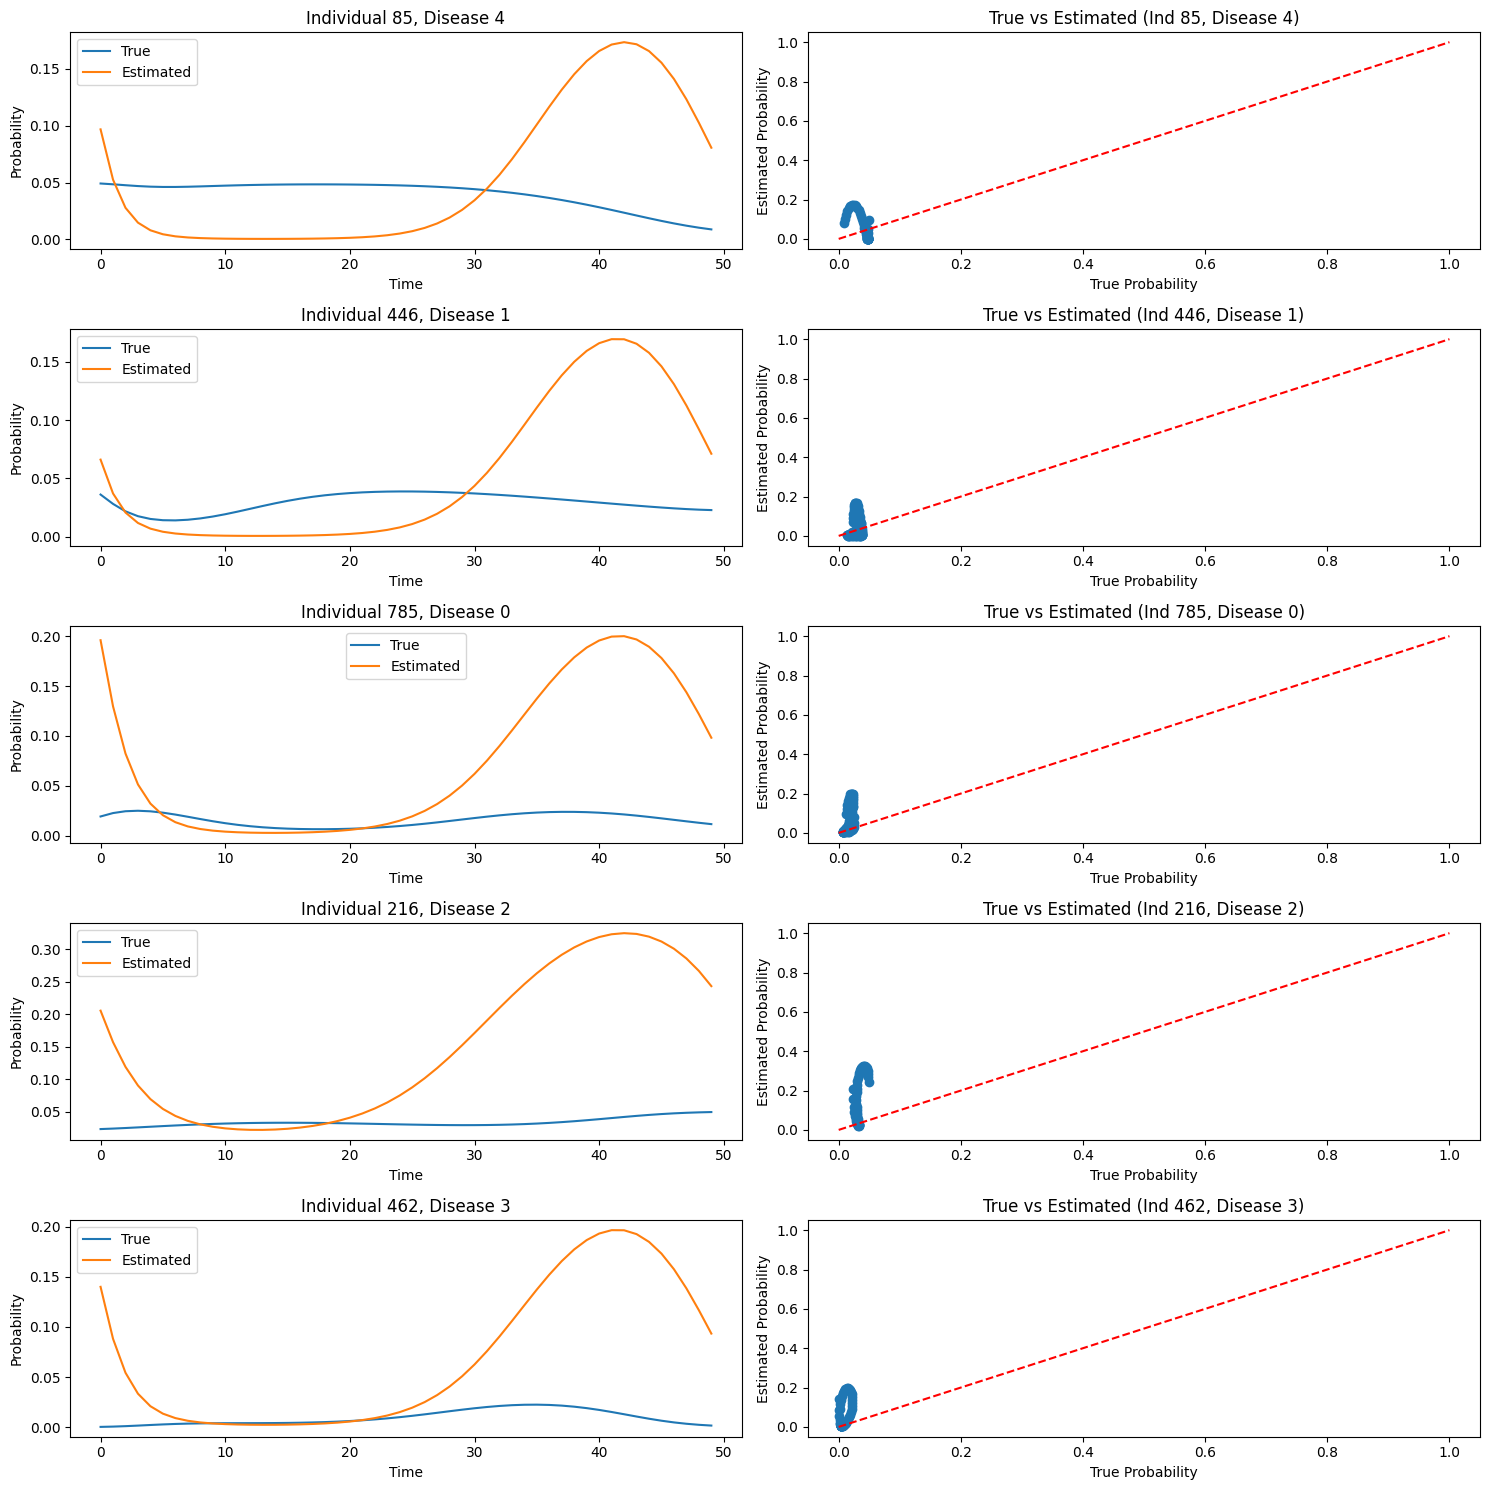

In [13]:

pi_true = expit(theta_true)/20
pi_fit = expit(theta_pred)
# Plot true vs estimated pi for a few randomly selected individuals and diseases
num_samples = 5
sample_individuals = np.random.choice(N, num_samples, replace=False)
sample_diseases = np.random.choice(D, num_samples, replace=False)

plt.figure(figsize=(15, 15))
for i, (n, d) in enumerate(zip(sample_individuals, sample_diseases)):
    print(i)
    print(n)
    print(d)
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(pi_true[n, d, :], label='True')
    plt.plot(pi_fit[n, d, :], label='Estimated')
    plt.title(f'Individual {n}, Disease {d}')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.scatter(pi_true[n, d, :], pi_fit[n, d, :])
    plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
    plt.xlabel('True Probability')
    plt.ylabel('Estimated Probability')
    plt.title(f'True vs Estimated (Ind {n}, Disease {d})')

plt.tight_layout()
plt.show()